In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as p
import matplotlib.font_manager as font_manager
import matplotlib.gridspec as gridspec
from matplotlib import colors

# Set font
plt.rc('font', family='serif', size=18)

bw_df = pd.read_csv("../csv/bandwidth.csv")
figurepath="../figures/"

# compute diverse metrics
received_fields=[]
restransmits_fields=[]
snd_cwnd_fields=[]
rt_bw_ratio_fields=[]
rt_snd_cwnd_ratio_fields=[]
xticklabels_time=[]
xticks_time=[]
loss_rates=[x/100 for x in list(range(0,21))]

received_fields_sec = []
for s in range(20):
    received_fields_sec.append("sum_received_at_{}".format(str(s)))
    
def bandwidth_per_sec(row):
    
    sub_index=0
    this_count = 0
    persec_sum = 0
    res=[]
    for f in received_fields:
        
        this_count += 1
        if this_count == 10:
            res.append(persec_sum)
            persec_sum = row[f]
            this_count = 0
            sub_index += 1
        else:
            persec_sum += row[f]

    return row.append(pd.Series(res, index=received_fields_sec))

for t in range(201):
    if t != 200:
        
        # Save up fields in order
        received="sum_received_at_"+str(t/10)
        received_fields.append(received)
        retransmits="retransmits_at_"+str(t/10)
        restransmits_fields.append(retransmits)
        snd_cwnd="snd_cwnd_at_"+str(t/10)
        snd_cwnd_fields.append(snd_cwnd)
        
        # RT Data received at
        rt_bw_ratio="retransmits_bandwidth_ratio_at_"+str(t/10)
        rt_bw_ratio_fields.append(rt_bw_ratio)
        
        bw_df[rt_bw_ratio] = 0.0
        selection =(bw_df[received] == 0) & (bw_df[retransmits] != 0)
        bw_df.loc[selection,rt_bw_ratio] = 100.0
        selection = (bw_df[received] != 0) & (bw_df[retransmits] != 0)
        bw_df.loc[selection,rt_bw_ratio] = bw_df.loc[selection,retransmits].astype(float) / bw_df.loc[selection,received].astype(float)*1500*100
        
        rt_snd_cwnd_ratio="retransmits_snd_cwnd_ratio_at_"+str(t/10)
        rt_snd_cwnd_ratio_fields.append(rt_snd_cwnd_ratio)
        bw_df[rt_snd_cwnd_ratio] = 0.0
        selection = (bw_df[snd_cwnd] == 0) & (bw_df[retransmits] != 0)
        bw_df.loc[selection,rt_snd_cwnd_ratio] = 100.0
        selection = (bw_df[snd_cwnd] != 0) & (bw_df[retransmits] != 0)
        bw_df.loc[selection,rt_snd_cwnd_ratio] = bw_df.loc[selection,retransmits].astype(float) / bw_df.loc[selection,snd_cwnd].astype(float)*1500*100
        
    if t%10 == 0:
        
        xticks_time.append(t)
        if t%50 == 0:
            xticklabels_time.append(str(int(t/10)))
        else:
            xticklabels_time.append("")
        
bw_df=bw_df.apply(bandwidth_per_sec, axis=1)
bw_df["total_received"] = bw_df[received_fields].sum(axis=1)

# ECN

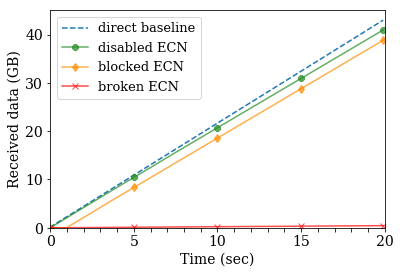

In [239]:
save=False
fig, ax = plt.subplots()
this_df = bw_df

data = this_df[(this_df.usecase == "forward") 
       & (this_df.experiment == "figure") & (this_df.configuration == "direct")
        & (this_df.packet_size == "default")][received_fields].max().cumsum()
ax.plot(data,label="direct baseline",linestyle="--")

data = this_df[(this_df.usecase == "ip-ecn") & (this_df.configuration == "indirect")
             & (this_df.experiment == "figure")][received_fields].median().cumsum()
ax.plot(data,label="disabled ECN", markevery=[0,50,100,150,199],
        marker="8", color="forestgreen", alpha=0.7)

data =  pd.Series([0 for x in range(10)]).append(this_df[(this_df.usecase == "tcp-ecn") 
                                                         & (this_df.configuration == "indirect")
             & (this_df.experiment == "figure")][received_fields].median()).cumsum().values
ax.plot(data,label="blocked ECN", markevery=[0,50,100,150,199],
        marker="d", color="darkorange", alpha=0.7)

data = this_df[(this_df.usecase == "ip-ecn-11") & (this_df.configuration == "indirect")
             & (this_df.experiment == "figure")][received_fields].median().cumsum()
ax.plot(data,label="broken ECN",markevery=[0,50,100,150,199], marker="x", color="red", alpha=0.7)

ax.set_xlim([0,200])
ax.set_xticks(xticks_time)
ax.set_xticklabels(xticklabels_time)
ax.set_xlabel("Time (sec)")

ax.set_ylim([0,90000000000])
ax.set_yticklabels(range(0,91,10))
ax.set_ylabel("Received data (GB)")

ax.legend(prop={'size': 13})

if save:
    plt.savefig(figurepath+"ecn-cumsum-nocong.png", dpi=200,aspect=2.0,bbox_inches = "tight")

_=_

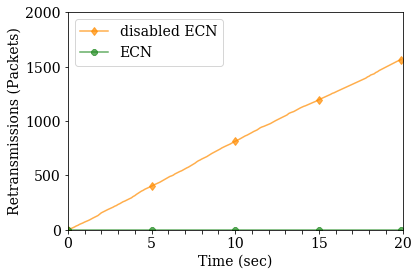

In [241]:
save=False
fig, ax = plt.subplots() 
this_df = bw_df

data = this_df[(this_df.usecase == "forward") 
               & (this_df.experiment == "wred") & (this_df.configuration == "indirect")
                & (this_df.packet_size == "default")
                & (this_df.loss==0)][restransmits_fields].max().cumsum()
ax.plot(data,label="disabled ECN", markevery=[0,50,100,150,199],marker="d", color="darkorange", alpha=0.7)

data = this_df[(this_df.usecase == "forward") 
               & (this_df.experiment == "wredecn") & (this_df.configuration == "indirect")
                & (this_df.packet_size == "default")
                & (this_df.loss==0)][restransmits_fields].max().cumsum()
ax.plot(data,label="ECN", markevery=[0,50,100,150,199],marker="8", color="forestgreen", alpha=0.7)

ax.set_xlim([0,200])
ax.set_xticks(xticks_time)
ax.set_xticklabels(xticklabels_time)
ax.set_xlabel("Time (sec)")

ax.set_ylabel("Retransmissions (Packets)")
ax.set_ylim([0,2000])
ax.legend(prop={'size': 14})

if save:
    plt.savefig("../figures/ecn-congestion-rt.png", dpi=200,aspect=2.0,bbox_inches = "tight")

_=_

# SACK

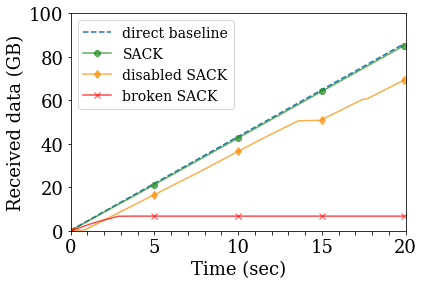

In [269]:
save=False
fig, ax = plt.subplots()
this_df = bw_df

data = this_df[(this_df.usecase == "forward") 
               & (this_df.experiment == "figure") & (this_df.configuration == "direct")
                & (this_df.packet_size == "default")
                & (this_df.loss==0)][received_fields].max().cumsum()
ax.plot(data,label="direct baseline",linestyle="--")

data = this_df.loc[this_df[(this_df.usecase == "forward") 
               & (this_df.experiment == "figure") & (this_df.configuration == "indirect")
                & (this_df.packet_size == "default")
                & (this_df.loss==0)]["bandwidth"].idxmax()][received_fields].cumsum()
ax.plot(data,label="SACK",markevery=[0,50,100,150,199],marker="8", color="forestgreen", alpha=0.7)

data = this_df.loc[this_df[(this_df.usecase == "loss-nosack") & (this_df.configuration == "indirect")
             & (this_df.experiment == "figure")& (this_df.loss==0)
             ]["bandwidth"].idxmax()][received_fields].cumsum()
ax.plot(data,label="disabled SACK",markevery=[0,50,100,150,199], marker="d", color="darkorange", alpha=0.7)

data = this_df.loc[this_df[(this_df.usecase == "rand-seqnum-sack") & (this_df.configuration == "indirect")
             & (this_df.experiment == "figure")
               & (this_df.loss==0)]["bandwidth"].idxmax()][received_fields].cumsum()
ax.plot(data,label="broken SACK",markevery=[0,50,100,150,199], marker="x", color="red", alpha=0.7)

ax.set_xlim([0,200])
ax.set_xticks(xticks_time)
ax.set_xticklabels(xticklabels_time)
ax.set_xlabel("Time (sec)")

ax.set_ylim([0,100000000001])
ax.set_yticklabels(range(0,101,20))
ax.set_ylabel("Received data (GB)")

ax.legend(prop={'size': 14})

if save:
    plt.savefig(figurepath+"sack-cumsum-noloss.png", dpi=200,aspect=2.0,bbox_inches = "tight")

_=_

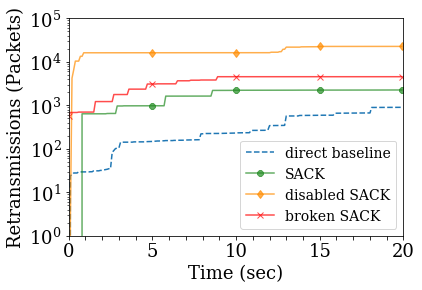

In [253]:
save=False
fig, ax = plt.subplots()     
this_df = bw_df

sub_df = this_df[(this_df.usecase == "forward") 
               & (this_df.experiment == "figure") & (this_df.configuration == "direct")
                & (this_df.packet_size == "default")
                & (this_df.loss==0)]
data = sub_df[np.isclose(sub_df.bandwidth, sub_df.median()["bandwidth"], 0.01)][restransmits_fields].mean().cumsum()
ax.plot(data,label="direct baseline",linestyle="--")

sub_df = this_df[(this_df.usecase == "forward") 
               & (this_df.experiment == "figure") & (this_df.configuration == "indirect")
                & (this_df.packet_size == "default")
                & (this_df.loss==0)]
data = sub_df[np.isclose(sub_df.bandwidth, sub_df.median()["bandwidth"], 0.0001)][restransmits_fields].mean().cumsum()
ax.plot(data,label="SACK",markevery=[0,50,100,150,199], marker="8", color="forestgreen", alpha=0.7)

sub_df = this_df[(this_df.usecase == "loss-nosack") 
               & (this_df.experiment == "figure") & (this_df.configuration == "indirect")
                & (this_df.loss==0)]
data = sub_df[np.isclose(sub_df.bandwidth, sub_df.median()["bandwidth"], 0.01)][restransmits_fields].mean().cumsum()
ax.plot(data,label="disabled SACK", markevery=[0,50,100,150,199],marker="d", color="darkorange", alpha=0.7)

sub_df = this_df[(this_df.usecase == "rand-seqnum-sack") 
                & (this_df.configuration == "indirect")
                & (this_df.loss==0)]
data = sub_df[np.isclose(sub_df.bandwidth, sub_df.max()["bandwidth"], 0.01)][restransmits_fields].mean().cumsum()

ax.plot(data,label="broken SACK", markevery=[0,50,100,150,199],marker="x", color="red", alpha=0.7)

ax.set_xlim([0,200])
ax.set_xticks(xticks_time)
ax.set_xticklabels(xticklabels_time)
ax.set_xlabel("Time (sec)")

ax.set_yscale("log", nonposy='clip')
ax.set_ylim([1,100000])
ax.set_ylabel("Retransmissions (Packets)")

ax.legend(prop={'size': 14})

if save:
    plt.savefig("../figures/sack-rt-noloss.png", dpi=200,aspect=2.0,bbox_inches = "tight")

_=_

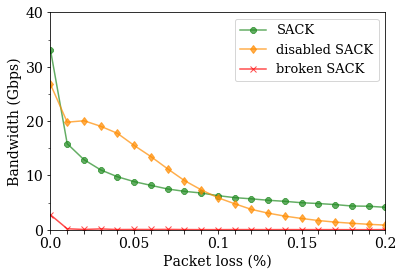

In [270]:
save=False
plt.rc('font', family='serif', size=14)
plt.rc('text', usetex=False)

fig, ax = plt.subplots()
this_df = bw_df

data=[]
for loss_rate in loss_rates:
    if loss_rate == 0:
        data.append(this_df[(this_df.usecase == "forward") & (this_df.configuration == "indirect")
                        & (this_df.experiment == "figure")]["bandwidth"].median())     
    else:
        data.append(this_df[(this_df.usecase == "loss-sack") & (this_df.configuration == "indirect")
                   
                 & (this_df.experiment == "figure") & (this_df.loss == loss_rate)]["bandwidth"].median())
ax.plot(data,label="SACK", marker="8", color="forestgreen", alpha=0.7)

data=[]
for loss_rate in loss_rates:
    data.append(this_df[(this_df.usecase == "loss-nosack") & (this_df.configuration == "indirect")
                 & (this_df.experiment == "figure") & (this_df.loss == loss_rate)]["bandwidth"].median())
    
ax.plot(data,label="disabled SACK", marker="d", color="darkorange", alpha=0.7)

data=[]
for loss_rate in loss_rates:
    data.append(this_df[(this_df.usecase == "rand-seqnum-sack") & (this_df.configuration == "indirect")
                & (this_df.experiment == "figure")
                        & (this_df.loss == loss_rate)]["bandwidth"].max())
ax.plot(data,label="broken SACK", marker="x", color="red", alpha=0.7)

ax.set_xlim([0,20])
ax.set_xticks(range(0,21))
ax.set_xticklabels([str(l) if i%5==0 else "" for i,l in enumerate(loss_rates)])
ax.set_xlabel("Packet loss (%)")

ax.set_ylim([0,40000000000])
ax.set_yticks(range(5*10**9,36*10**9,10*10**9), minor=True)
ax.set_yticklabels(["0","10","20", "30", "40"])
ax.set_ylabel("Bandwidth (Gbps)")

ax.legend(prop={'size': 13})

if save:
    plt.savefig("../figures/sack-bw.png", dpi=200,aspect=2.0,bbox_inches = "tight")

_=_

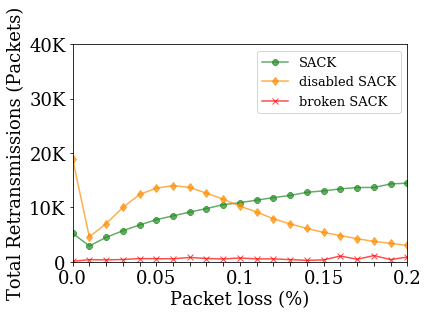

In [250]:
# cdf Absolute retransmissions
save=True
fig, ax = plt.subplots()
this_df = bw_df

data=[]
for loss_rate in loss_rates:
    if loss_rate == 0:
        data.append(this_df[(this_df.usecase == "forward") & (this_df.configuration == "indirect")
                            & (this_df.experiment == "figure")  
                            & (this_df.loss == loss_rate)]["total_retransmits"].median())   
    else:
        data.append(this_df[(this_df.usecase == "loss-sack") & (this_df.configuration == "indirect")
                         & (this_df.experiment == "figure") 
                            & (this_df.loss == loss_rate)]["total_retransmits"].median())
ax.plot(data,label="SACK", marker="8", color="forestgreen", alpha=0.7)

data=[]
for loss_rate in loss_rates:
    data.append(this_df[(this_df.usecase == "loss-nosack") & (this_df.configuration == "indirect")
                 & (this_df.experiment == "figure") 
                        & (this_df.loss == loss_rate)]["total_retransmits"].median())
ax.plot(data,label="disabled SACK", marker="d", color="darkorange",alpha=0.7)

data=[]
for loss_rate in loss_rates:
    data.append(this_df[(this_df.usecase == "rand-seqnum-sack") & (this_df.configuration == "indirect")
                 & (this_df.experiment == "figure")
                        & (this_df.loss == loss_rate)]["total_retransmits"].median())
ax.plot(data,label="broken SACK", marker="x", color="red", alpha=0.7)

ax.set_xlim([0,20])
ax.set_xticks(range(0,21))

ax.set_xticklabels([str(l) if int(l*100)%5==0 else "" for l in loss_rates])
ax.set_xlabel("Packet loss (%)")

ax.set_ylim([0,40000])
ax.set_yticklabels(["{}K".format(l) if l!=0 else "0" for l in range(0,51,10)])
ax.set_ylabel("Total Retransmissions (Packets)")

ax.legend(prop={'size': 13})

if save:
    plt.savefig("../figures/sack-rt.png", dpi=200,aspect=2.0,bbox_inches = "tight")

_=_

# WScale

/usr/lib/python3/dist-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


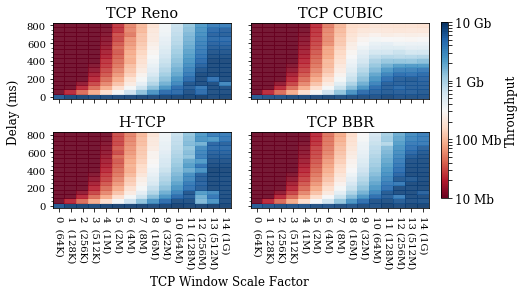

In [2]:
from matplotlib.ticker import LogFormatter 

save=False
fig, axs = plt.subplots(2,2,sharex=True, sharey=True) 

plt.rc('font', family='serif', size=12)
cc_algo=["reno", "cubic", "htcp", "bbr"]

these_df = [this_df for this_df in [bw_df[(bw_df.usecase == "wscale" ) 
                 & (bw_df.experiment == "figure")
                 & (bw_df.congestion_control == cc)] for cc in cc_algo]]
    
group_fields = ["delay","wscale"]
c=[]
df=(these_df[0][group_fields+["bandwidth"]].groupby(group_fields).median())
c.append(axs[0,0].pcolor(df.unstack(),cmap='RdBu',
                     norm=colors.LogNorm(10000000,10000000000),alpha=0.9))
df=(these_df[1][group_fields+["bandwidth"]].groupby(group_fields).median())
c.append(axs[0,1].pcolor(df.unstack(),cmap='RdBu',
                     norm=colors.LogNorm(10000000,10000000000),alpha=0.9))
df=(these_df[2][group_fields+["bandwidth"]].groupby(group_fields).median())
c.append(axs[1,0].pcolor(df.unstack(),cmap='RdBu',
                     norm=colors.LogNorm(10000000,10000000000),alpha=0.9))
df=(these_df[3][group_fields+["bandwidth"]].groupby(group_fields).median())
c.append(axs[1,1].pcolor(df.unstack(),cmap='RdBu',
                     norm=colors.LogNorm(10000000,10000000000),alpha=0.9))

wscale_labels=["0\n64K   ", "1\n128K   ","2\n256K ","3\n  512K","4\n  1M","5\n 2M",
              "6\n4M","7\n8M","8\n16M","9\n32M","10\n64M","11\n128M",
              "12\n256M","13\n512M","14\n1G"]
wscale_labels=["0  (64K)", "1  (128K)","2  (256K)","3  (512K)","4  (1M)","5  (2M)",
              "6  (4M)","7  (8M)","8  (16M)","9  (32M)","10 (64M)","11 (128M)",
              "12 (256M)","13 (512M)","14 (1G)"]
axs[0,0].set_xticks([x-0.5 for x in filter(lambda x: x, range(0,16))])
axs[0,0].set_xlim([0,15])
axs[1,1].set_xticklabels(wscale_labels,rotation=-90)
axs[1,0].set_xticklabels(wscale_labels,rotation=-90)

axs[0,0].set_yticks([x+0.5 for x in filter(lambda x: x%4 == 0, range(18))])
axs[0,0].set_yticks([x+0.5 for x in filter(lambda x: x%4 != 0, range(18))], minor=True)
axs[0,0].set_ylim([0,17])

# *2 because it's bidirectional
axs[0,0].set_yticklabels([str(d) for d in filter(lambda x: x%200 == 0, sorted(these_df[0].delay.unique()*2))])
axs[0,0].set_title("TCP Reno")
axs[0,1].set_title("TCP CUBIC")
axs[1,0].set_title("H-TCP")
axs[1,1].set_title("TCP BBR")

plt.gcf().subplots_adjust(bottom=0.25,left=0.1,right=0.90)
fig.text(0.0, 0.59, 'Delay (ms)', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0., 'TCP Window Scale Factor', ha='center', va='center')

formatter = LogFormatter(10, labelOnlyBase=False) 
cbaxes = fig.add_axes([0.99, 0.29, 0.015, 0.61])

cbar=fig.colorbar(c[3], ax=fig.get_axes(),cax=cbaxes, label="Throughput",
                  fraction=0.05, pad=0.05, anchor=(0.0, 0.5))
cbar_index=["10 Mb", "100 Mb","1 Gb","10 Gb"]
cbar.ax.set_yticklabels([cbar_index[int(i/9)] if not i%9 else "" for i in range(28)])

plt.tight_layout()

if save:
    plt.savefig("../figures/wscale-hm.png", dpi=200, aspect=2.0,bbox_inches = "tight")

_=_